## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [7]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

При загрузке данных:
* для различимости столбцов и методов таблицы, первые буквы названий столбцов приведены к заглавным
* добавлен столбец `Date`, где признак `timestamp` преобразован в `datetime`

Значения в датасете уже отсортированы по `UserID`, `MovieID`.

In [375]:
user_rate = pd.read_csv('../data/movies/user_ratedmovies-timestamps.dat', sep='\t')
user_rate.columns = [c.strip()[0].capitalize() + c.strip()[1:] for c in user_rate.columns]
user_rate['Date'] = user_rate.Timestamp.apply(lambda x: datetime.fromtimestamp(x / 1000.))
user_rate.head()

UserID  MovieID  Rating      Timestamp                Date
0      75        3     1.0  1162160236000 2006-10-30 01:17:16
1      75       32     4.5  1162160624000 2006-10-30 01:23:44
2      75      110     4.0  1162161008000 2006-10-30 01:30:08
3      75      160     2.0  1162160212000 2006-10-30 01:16:52
4      75      163     4.0  1162160970000 2006-10-30 01:29:30

In [376]:
uniq_users = user_rate.UserID.unique()
uniq_movies = user_rate.MovieID.unique()
uniq_users.shape[0], uniq_movies.shape[0]
user_rate.UserID.max() - user_rate.UserID.min(), user_rate.MovieID.max() - user_rate.MovieID.min()

(2113, 10109)

(71459, 65132)

Как видно из предыдущего шага, значения полей `UserID`, `MovieID` принимают достаточно далекие друг от друга значения - имеется множество пропусков. Для того, чтобы матрицы пользователи-фильмы не содержали много лишней информации, данные значения переводятся в последовательно расположенные, начиная с 0.

In [377]:
def reindex(df, column: str, result: str) -> None:
    """ Добавление столбца [result], содержащего индексы уникальных значений [column] """
    uniq = df[column].unique()
    df[result] = df[column].map(pd.Series(range(uniq.shape[0]), index=uniq).to_dict())

In [378]:
reindex(user_rate, 'UserID', 'UId')
reindex(user_rate, 'MovieID', 'MId')
user_rate.head()

UserID  MovieID  Rating      Timestamp                Date  UId  MId
0      75        3     1.0  1162160236000 2006-10-30 01:17:16    0    0
1      75       32     4.5  1162160624000 2006-10-30 01:23:44    0    1
2      75      110     4.0  1162161008000 2006-10-30 01:30:08    0    2
3      75      160     2.0  1162160212000 2006-10-30 01:16:52    0    3
4      75      163     4.0  1162160970000 2006-10-30 01:29:30    0    4

При разбиении на выборки используется группировка по `UserID`. Для выполнения условий разбиения, таблица сортируется по `Timestamp` внутри каждого пользователя.

In [379]:
user_rate.sort_values(by=['UserID', 'Timestamp', 'MovieID'], ascending=True, inplace=True)
test_df = user_rate.groupby('UserID').apply(lambda x: x[-5:])
valid_df = user_rate.groupby('UserID').apply(lambda x: x[-10:-5])
train_df = user_rate.groupby('UserID').apply(lambda x: x[:-10])
train_valid_df = user_rate.groupby('UserID').apply(lambda x: x[:-5])

assert sum((test_df.shape[0], valid_df.shape[0], train_df.shape[0])) == user_rate.shape[0]

In [541]:
def get_sparse(df, target: str="Rating", x: str="UId", y: str="MId"):
    """ Перевод в разреженную матрицу """
    return sparse.csr_matrix((df[target].values, (df[x].values, df[y].values)))

In [426]:
X_full = get_sparse(user_rate)
X_test = get_sparse(test_df)
X_valid = get_sparse(valid_df)
X_train = get_sparse(train_df)
X_train_valid = get_sparse(train_valid_df)

X_full.shape[1], X_test.shape[1], X_valid.shape[1], X_train.shape[1], X_train_valid.shape[1]
# для проверки следующего шага
X_test.sum(), X_valid.sum(), X_train.sum(), X_train_valid.sum()

(10109, 10105, 10098, 10109, 10109)

(37995.5, 37923.0, 2865580.5, 2903503.5)

Полученные наборы данных имеют разный размер, что представляется неудобным для дальнейшего обучения, поэтому используется другой способ.

In [421]:
def get_indexes(df, shape: tuple=X_full.shape):
    """ Получение матрицы индексов заполненных пользователями оценок """
    indexes = np.zeros(shape)
    for idx, jdx in zip(df.UId, df.MId):
        indexes[idx, jdx] = 1
    return indexes

In [427]:
X_test_idx = get_indexes(test_df)
X_valid_idx = get_indexes(valid_df)
X_train_idx = get_indexes(train_df)
X_train_valid_idx = get_indexes(train_valid_df)

# разбиение на выборки путем обнуления определенных значений в полной матрице пользователи-фильмы
X_test = X_full.toarray() * X_test_idx
X_valid = X_full.toarray() * X_valid_idx
X_train = X_full.toarray() * X_train_idx
X_train_valid = X_full.toarray() * X_train_valid_idx

X_full.shape[1], X_test.shape[1], X_valid.shape[1], X_train.shape[1], X_train_valid.shape[1]
# проверка корректности преобразования
X_test.sum(), X_valid.sum(), X_train.sum(), X_train_valid.sum()

(10109, 10109, 10109, 10109, 10109)

(37995.5, 37923.0, 2865580.5, 2903503.5)

Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [428]:
""" Недостаток данной реализации обеих функций в том, что берутся топ-5 значений, 
    вне зависимости от существования реального значения оценки пользователя """

def sparse_to_array(x):
    if isinstance(x, sparse.csr_matrix):
        return x.toarray()
    return x

def rmse_score(y_true, y_predicted, k: int=5) -> float:  # --> min
    y_true_ = sparse_to_array(y_true)
    y_predicted_ = sparse_to_array(y_predicted)
    n = y_predicted_.shape[0]
    
    rmse = 0
    for idx in range(n):
        top_k = sorted(zip(y_predicted_[idx], y_true_[idx]), key=lambda x: x[0], reverse=True)[:k]
        rmse += np.sqrt(np.sum(np.diff(top_k, axis=1)**2)/k)
    return rmse/n

def ndcg_score(y_true, y_predicted, k: int=5) -> float:  # --> max
    def g(r):
        return 2**r - 1
        
    def d(i):
        return 1/np.log2(i + 1)
    
    y_true_ = sparse_to_array(y_true)
    y_predicted_ = sparse_to_array(y_predicted)
    n = y_predicted_.shape[0]
    
    dcg = np.zeros(n)
    for idx in range(n):
        top_k = sorted(zip(y_predicted_[idx], y_true_[idx]), key=lambda x: x[0], reverse=True)[:k]
        dcg[idx] = np.sum([g(r_ui)*d(i + 1) for i, (_, r_ui) in enumerate(top_k)])
    max_dcg = np.max(dcg)
    if not max_dcg:
        print("Max DCG == 0")  # особенность реализации
        return None
    
    return np.sum(dcg/max_dcg)/n

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [438]:
def get_most_pop(df):
    most_pop = np.zeros((df.shape[0], df.shape[1]))
    shape_idx = 1 if isinstance(df, sparse.csr_matrix) else 0  # faster then reshaping
    for idx, movie_row in enumerate(df.T):
        n = movie_row[movie_row != 0].shape[shape_idx]
        most_pop[:, idx] = movie_row.sum()/n if n else 0
    assert (most_pop.sum(axis=0)/most_pop.shape[0] - most_pop[0] < 1e-11).all()
    return most_pop

In [544]:
most_pop = get_most_pop(X_test)
print("RMSE: {}".format(rmse_score(X_test, most_pop, k=5)))
print("nDCG: {}".format(ndcg_score(X_test, most_pop, k=5)))

RMSE: 4.998501095944155
nDCG: 0.0015784722792777728


Данный метод очень плохо предсказывает топ 5 оценок пользователя.

*Замечание:* в то же время, метод оценивания в случае с **most popular**-предсказанием имеет существенный недостаток - поскольку оценивание производится на основе топ-5 предсказанных оценок пользователей, а поскольку все оценки фильма одинаковы для всех пользователей, берутся просто первые 5 оценок, для которых может не существовать правильного ответа.

Особенно показательным в данном случае является обучение на выборке `train` + `valid`:

In [545]:
most_pop = get_most_pop(X_train_valid)
print("RMSE: {}".format(rmse_score(X_test, most_pop, k=5)))
print("nDCG: {}".format(ndcg_score(X_test, most_pop, k=5)))

RMSE: 5.0
Max DCG == 0
nDCG: None


**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [441]:
from sklearn.decomposition import TruncatedSVD

In [451]:
%%time
svd = TruncatedSVD(random_state=RANDOM_SEED)
n_components = np.linspace(2, 100, 10, dtype=int)

rmse_scores = []
ndcg_scores = []
for idx, n_comp in enumerate(n_components):
    svd = svd.set_params(n_components=n_comp).fit(X_train)
    # inverse transform == svd.transform(X).dot(svd.components_)
    X_hat = svd.inverse_transform(svd.transform(X_valid))
    rmse_scores.append(rmse_score(X_valid, X_hat, k=5))
    ndcg_scores.append(ndcg_score(X_valid, X_hat, k=5))

CPU times: user 7min 15s, sys: 11.5 s, total: 7min 27s
Wall time: 6min 23s


best RMSE: 0.14438840548886542
best nDCG: 0.27773062137540677


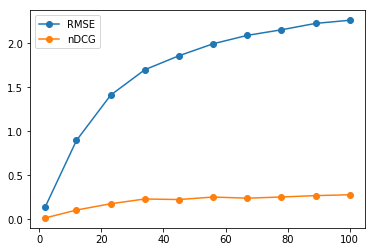

In [546]:
_ = plt.plot(n_components, rmse_scores, '-o', n_components, ndcg_scores, '-o')
_ = plt.legend(['RMSE', 'nDCG'])
print("best RMSE: {}".format(min(rmse_scores)))
print("best nDCG: {}".format(max(ndcg_scores)))

In [568]:
list(zip(rmse_scores, ndcg_scores))

[(0.14438840548886542, 0.014664226800509021),
 (0.8953616430357219, 0.10411026764450558),
 (1.4100352159262513, 0.17571655967860839),
 (1.6993016603161497, 0.2297523689837621),
 (1.85794234718401, 0.2236455780000259),
 (1.9941044851406151, 0.25187897951337135),
 (2.089661645891929, 0.2391566842397971),
 (2.1530823027574146, 0.25254618229495635),
 (2.225827296080948, 0.2682159869947747),
 (2.261607406605564, 0.27773062137540677)]

Исходя из полученных результатов, лучшим рангом разложения с точки зрения `RMSE` является 2, а с точки зрения `nDCG` - 100.

Ориентироваться только на `RMSE` нельзя, поскольку данная метрика оценивает только качество прогноза, а не рекомендации (`nDCG` учитывает реальные значения).

Предположительно, оптимальным в данном случае можно считать ранг = 56.

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

In [535]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [538]:
def collaborative_filtering(df, w_metrics, metrix, alpha: float=0.9):
    result = np.zeros((df.shape[0], df.shape[1]))
    shape_idx = 1 if isinstance(df, sparse.csr_matrix) else 0  # faster then reshaping
    for idx in range(df.shape[0]):
        u = df[idx]
        u_mean = u.sum()/u[u != 0].shape[shape_idx]
        a, b = np.zeros_like(u), 1
        for jdx in range(X_train.shape[0]):
            if idx == jdx:
                continue  # skip current user
            v = df[jdx]
            v_mean = v.sum()/v[v != 0].shape[shape_idx]
            w_uv = w_metrics(u, v)
            if w_uv > alpha:
                a += w_uv * metrix(v, v_mean)
                b += w_uv
        result[idx] = u_mean + a / b
    return result

В качестве меры сходства пользователей $u$, $v$ используется: $\frac{1}{MAE(u, v) + 1}$,
$(r_{vi} - \bar{r_v}) = \frac{1}{|r_{vi} - \bar{r_v}| + 1}$

In [569]:
%%time
w_metrics = lambda x, y: 1/(mean_absolute_error(x, y) + 1)
metrix = lambda x, y: 1/(abs(x - y) + 1)

t = collaborative_filtering(X_train_valid, w_metrics, metrix)
print("RMSE: {}".format(rmse_score(X_test, t, k=5)))
print("NDCG: {}".format(ndcg_score(X_test, t, k=5)))

RMSE: 3.7931482899706173
NDCG: 0.013888739513143395
CPU times: user 12min 21s, sys: 531 ms, total: 12min 21s
Wall time: 12min 33s


In [570]:
%%time
w_metrics = lambda x, y: np.corrcoef(x, y)
metrix = lambda x, y: 1/(abs(x - y) + 1)

t = collaborative_filtering(X_train_valid, w_metrics, metrix)
print("RMSE: {}".format(rmse_score(X_test, t, k=5)))
print("NDCG: {}".format(ndcg_score(X_test, t, k=5)))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Полученная реализация алгоритма коллаборативной фильтрации дает худшие результаты по сравнению с разложением матрицы рейтингов с помощью разреженного SVD. 

Возможно, это обусловлено неправильно подобранными мерой сходства и метрикой $(r_{vi} - \bar{r_v})$.

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

Лучшим методом с точки зрения обеих метрик оказался метод раздожения матрицы рейтингов с помощью разреженного SVD.

Данный результат обусловлен описанными выше особенностями реализации метрик и алгоритма коллаборативной фильтрации.

**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?

* `RMSE` - только качество прогноза, а не рекомендации (`nDCG` учитывает реальные значения)
* `nDCG` - не учитывает сходство преальной оценки и прогноза

Еще можно использовать:
* `logloss` - учитывает качество прогноза
* `MAE` - учитывает качество рекомендации
* `precision`, `recall`, `f1-score`